# Clonotype definition
# Clonal expansion: diversity and abundance

In general, the lymphocytes are in dormance state until received and external signal (epitope recognition of forigne agent) or stimulation from autocrine agents (signaling from same organism as response from innate immune system). As consecuence, the specific cells proliferate dramatically to fullfill the defense response they are programmed to performed. This phenomenon is known as clonal expansion, this name is a reference from the recognitions of the proliferation of a specific cells given the high number of the same IR through a large number of different cells (expanded clones). This expansion provides hints of differentiation from naive lymphocytes to mature effector and memory lymphocytes helping in the intepretation and expected results regarding previous cell annotation. On the ohter hand, the analysis of expanded clones must take into account derivative processes as clonal competitions (tow or more clones in expansion competing for the same space), clonal dominance (one single clonal expanded cell outnumbering the rest of clonal cells), and bystander activation (activation of T-cells by cytokines but not for T-cell receptor coupling).

https://www.nature.com/articles/s12276-019-0316-1
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5654265/#:~:text=Clonal%20dominance%20occurs%20when%20a,dominant%20is%20not%20entirely%20conclusive.
https://www.nature.com/articles/s41588-020-0638-x#:~:text=Many%20normal%20tissues%20are%20populated,effectively%20annulling%20one%20another's%20advantages.
https://onlinelibrary.wiley.com/doi/epdf/10.1038/icb.2015.104

The dynamic changes in terms of number of cells per clonotype in a given space allowed to applied concpets from population biology such as diversity and abundace. Diversity is defined as the number of species and their abundace in an area or community, whereas the abundance is the number or frequency of individuals of the same species. Here, we can replace the term species by clones to make clear their relevance in single-cell IRs analysis. Then, if a high clonal expansion is detected in a specific cell-type, e.g., effector CD8+ T-cells, the number of clones are expected to be reduced given that the expanded clones have taken space regarding the total number of cells detected for this specific cell-type, therefore, we could expect a reduction in the diversity for this cell-type. On the other hand, we could expect an increase of abundance regarding the expanded clones due to they were increased the number of individuals (cells) belonging this specific clone (observed by number of cells por clone ID).

https://www.frontiersin.org/articles/10.3389/fenvs.2018.00011/full#:~:text=Abundance%20is%20defined%20as%20%E2%80%9Cthe,et%20al.%2C%202003).

# Gene segment usage and spectratype

The process to shape a T-cell or B-cell receptor by the rearrengment of the V(D)J segments is though to generate random sequences and, in consecuence, the distribution of V(D)J sequences should follows a uniform distribution. Nevertheless, it has been observed the V(D)J gene usage frequency is largly consistent across different individuals, which suggests a preference selection in terms of the V(D)J gene segments used. That allows the analysis of gene segment usage in terms of abundance of most used gene segments per cell-type and frequency of most abundant segment per cell-type per individual. Likewise, considering the abundances is possible to identify the exact combinantions of V(D)J segments of interest.

https://www.pnas.org/doi/epdf/10.1073/pnas.1409572111
https://www.frontiersin.org/articles/10.3389/fimmu.2021.815680/full#:~:text=VDJ%20Gene%20Usage%20in%20IgM%20Repertoires%20of%20Rhesus%20and%20Cynomolgus%20Macaques,-Mark%20Chernyshev%2C%20Mateusz&text=Macaques%20are%20frequently%20used%20to,na%C3%AFve%20immunoglobulin%20(IG)%20repertoires.

On the other hand, the recombination of V(D)J gene segments and the imprecise junction of V and J segments produces CDR3 regions with variable length. Spectratype analysis is seen as the measurement of the heterogeneity of CDR3 regions by their lenght diversity across the different cell-types. This measurement in combination to clonal expansion and gene segment usage provides evidences to define well described immunodominant clonotypes.

https://bmcimmunol.biomedcentral.com/articles/10.1186/1471-2172-14-35
https://watermark.silverchair.com/bti539.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAycwggMjBgkqhkiG9w0BBwagggMUMIIDEAIBADCCAwkGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM7zXFeJmJPL4AnJbSAgEQgIIC2gF96WPFe0UjZbTgTGVGyUjkRvSEAAPDWzC9XpZlZ2WRy9a1TILh3P4TeLaafpmQjLcd2zX0nzGr7RUnJu6wbm7XKpBdnHaC9exlUqCdIev9s3K-0yWKb0MMFq4CuTumtMxyQtko1CBqxcBhV-TashK-FTMZQkLadLuyLyqJ5xZZwlHtm1n_xBvg8PgQSI4tlNJQnw9h4Z169cxr9YDoZeFfthkTvgbQitDL0TRGqQZt2bEznAaBGQYFLiUU-PpMak3O9XcLiYk0XjMUzX5CfgXo9TFl9Im1WkGsnHEBrhx0dWiq7pXAMSI63xdlbotPZdol0CxxPtpvvZxTE8xHfhquKop0s9PK2e8JZohyE-iiV-LfV2Jb152yrF2x-Y6qffYiUrNhpy7X_7Hl1mNHtgpzFFQeqrg53AEviCKTPjKgxgL8ywfXyX67GfrJM-3sfDGufn-IlbMQczbQScHXUzQHtmWkhSylN_vtYFi1c9SyZzujYmLuQW_Up7IunqIaDFxn2s3ddZdZ8XE7-WRGFQxmrAofLM83RjfwEF0bp5_c37j3vKmR0jrKBhXl_53k24FGohz5S4xlwOKjPapuM54B86off-MQtBS7ERGlYY6Pdpuq62GvFyt8UwBlsP4k0mvrdSzBo6VafHqPjdoOeBudDz4WwEie4oKI8yChn9H0J5LUvlJt5jta2oEysaF95WhpEWwamqJWBJ2rXdQe6863Tvw30ZLqdmMCxEi0AhXuZm5xqI94wlEINBncQVaup8gWsxs0EhsqQm_jcXVZMBN5VDOB60-KUX2ERvuGeCsnoBvFxaj55Ymc7lqU0o4rKaSSaBc8n0-_vzUg5LjsLY0nOESPLFt-uNdFDUF7EB4-hFGQTal8agJLVTd0TxObAq9ry-5kmoWbgMwOVu8ocn7EwXx9dhUMz9rbu8f7x11UCPq0K0nYUsfPUkKXKsWgQnD5j06UgPz_2VE

# Repertoire comparison

# TCR Data Analysis with Scirpy

Let's first load the libraries and the annData with the pre-processed IRs to run the clonotype detection [`Clonality`](#Clonality).

In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
    ".*IProgress not found*",
)
warnings.simplefilter(action="ignore", category=FutureWarning)

import scanpy as sc
import scirpy as ir
import pandas as pd
import numpy as np
import seaborn as sb

warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

In [2]:
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.2
sinfo       0.3.4
-----
Levenshtein                 NA
PIL                         8.4.0
adjustText                  NA
airr                        1.3.1
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                     2021.10.08
cffi               

In [2]:
path_data = "/home/icb/juan.henao/BestPracticeStart/data"

path_gex = f"{path_data}/TCR_filtered.h5ad"
adata = sc.read(path_gex)

/home/juan.henao/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


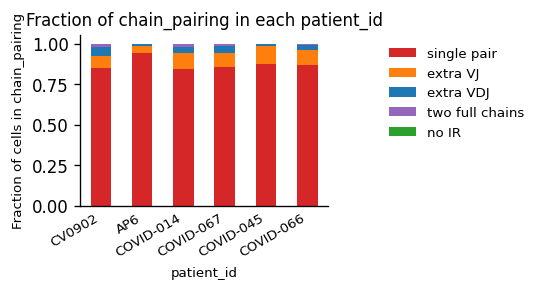

In [3]:
# Downsampling

adata = adata[
    adata.obs["patient_id"].isin(["COVID-014", "CV0902", "AP6", "COVID-045", "COVID-066", "COVID-067"])
]
# adata[adata.obs['Status'] == 'Healthy'].obs['patient_id']
_ = ir.pl.group_abundance(
    adata, groupby="patient_id", target_col="chain_pairing", normalize=True
)

# Clonotype definition

First, it is necessary to compute a distance of similarity/identity between the different unique nucleotide or amino acid sequences for both chains, VJ and VDJ. The distance matrix is located at adata.uns and is used to match cells 

In [3]:
ir.pp.ir_dist(
    adata,
    sequence="aa",
    cutoff=15,
)

In [4]:
# Using the previous calculated distances, this function identifies clusters of similar sequences (a.k.a. clonotypes)

ir.tl.define_clonotype_clusters(
    adata, sequence="aa", receptor_arms ="all", dual_ir="any"
)

  0%|          | 0/176451 [00:00<?, ?it/s]

In [6]:
# This function use the previous results in the clonotype identification to allow the visualization of them
# as networks

ir.tl.clonotype_network(adata, min_cells=3, sequence="aa")

<AxesSubplot:>

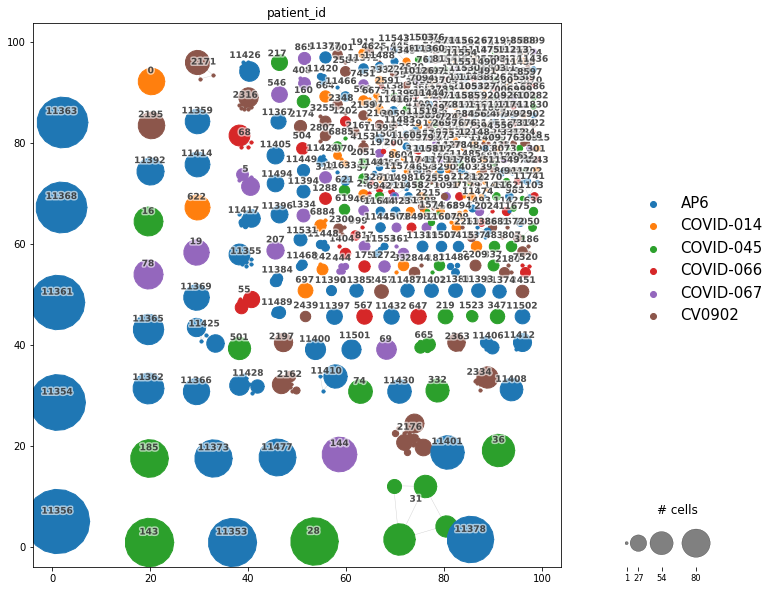

In [7]:
# Plotting the clonotypes as networks

# Public clonotype: Term to referer a clonotype present in multiple samples, e.g., the clonotype '0'
# Private clonotype: Term to refer a clonotype present exclusively in a specific sample, e.g., clonotype '10982'

ir.pl.clonotype_network(
    adata,
    color="patient_id",
    base_size=10,
    label_fontsize=9,
    panel_size=(10, 10),
    legend_fontsize=15,
)

In [8]:
# Clonotype names as strings
adata.obs["cc_aa_identity"] = adata.obs["cc_aa_identity"].astype("str")

In [9]:
# Example of the information necessary to perform further analysis
# The first two columns show the CDR3-alpha region
# The next two columns show the CDR3-beta region
# The next column shows the receptor subtype (T-cell receptor-alpha (TRA), T-cell receptor-beta (TRB))
# The last column shows the number of cells which that specific T-cell receptor were detected

adata.obs.loc[adata.obs["cc_aa_identity"] == "31", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells


In [14]:
adata.obs.loc[adata.obs["cc_aa_identity"] == "0", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells


# Clonal expansion

The positive selection of immune cells, e.g. for immune response activation, causes their clonality (division) relected in the representation of clonotypes in one or more cells. The first step is to identify the clonal expansion and add a column in the .obs table. 

Once the clonal expansion has been identified, it is easy to observe that ploting the raw number of cells per cell-type correspinding to expanded clones as a stacked barplot.

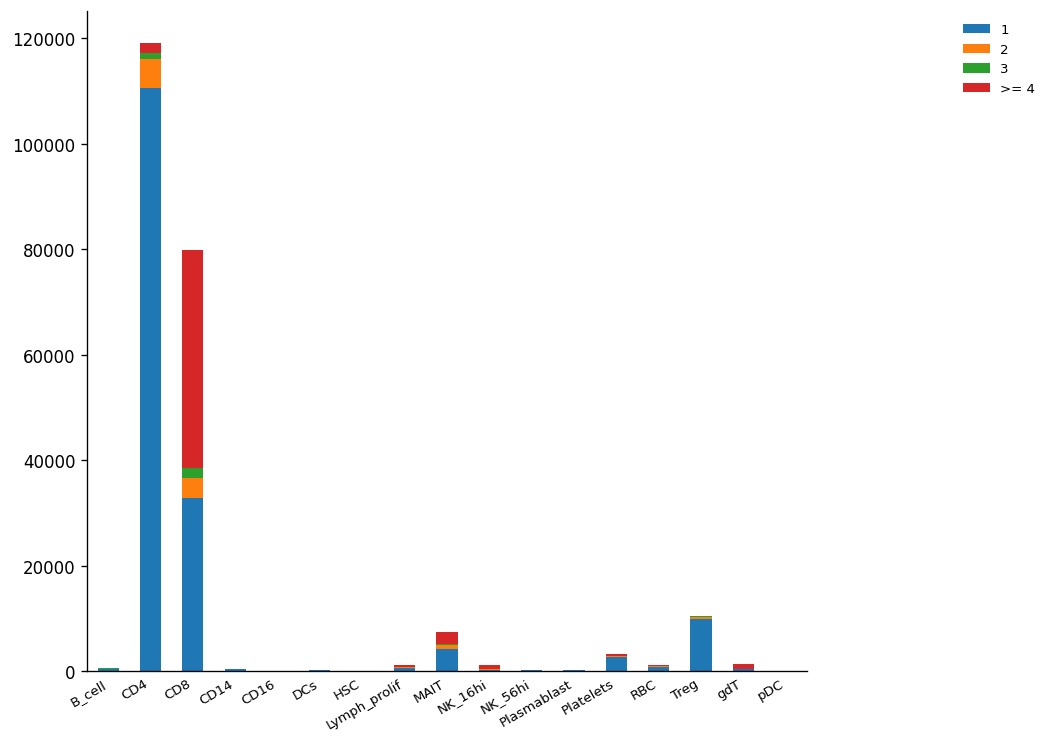

In [5]:
ir.tl.clonal_expansion(adata, target_col = "cc_aa_identity")

_ = ir.pl.clonal_expansion(
    adata, groupby="initial_clustering", target_col = "cc_aa_identity",
    clip_at=4, normalize=False, figsize=[10, 10]
)

The plot above tell us that CD4 is the most abundant cell-type, however, CD8 shows the highest number of clonotypes expanded, it could be possibly by positive selection of CD8 effector cells.

Another way to obser clonal expansion is normalizing the size of cell-type clusters. Here, the clonal expansion differences between CD4 and CD8 are more clear.

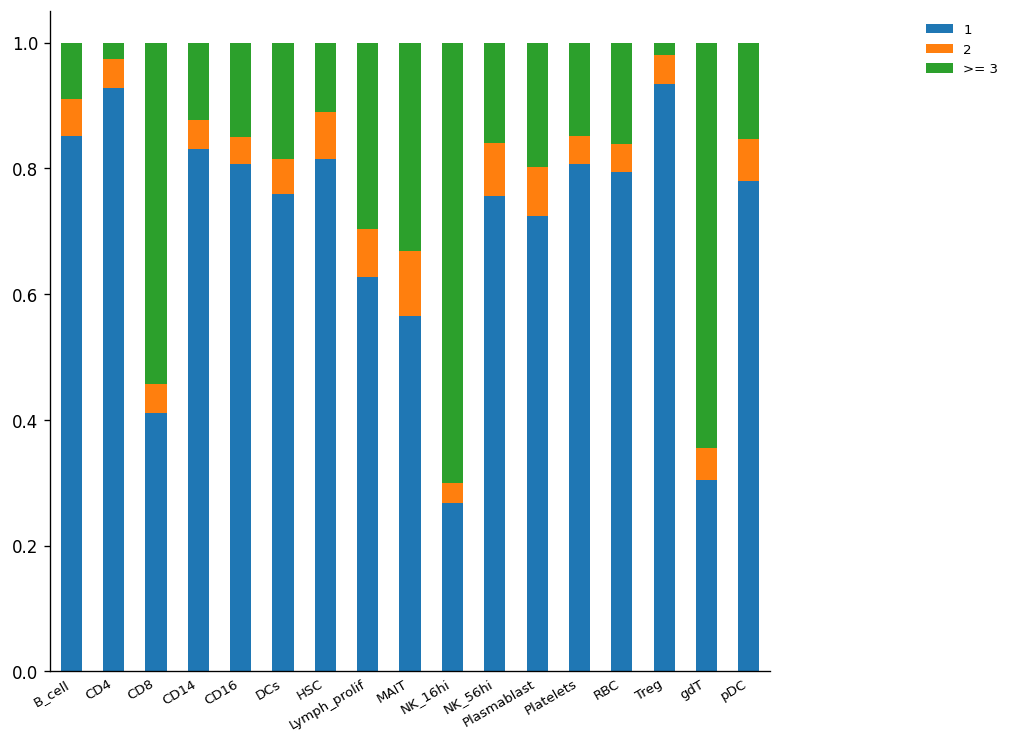

In [6]:
_ = ir.pl.clonal_expansion(adata, "initial_clustering", target_col = "cc_aa_identity", figsize=[10, 10])

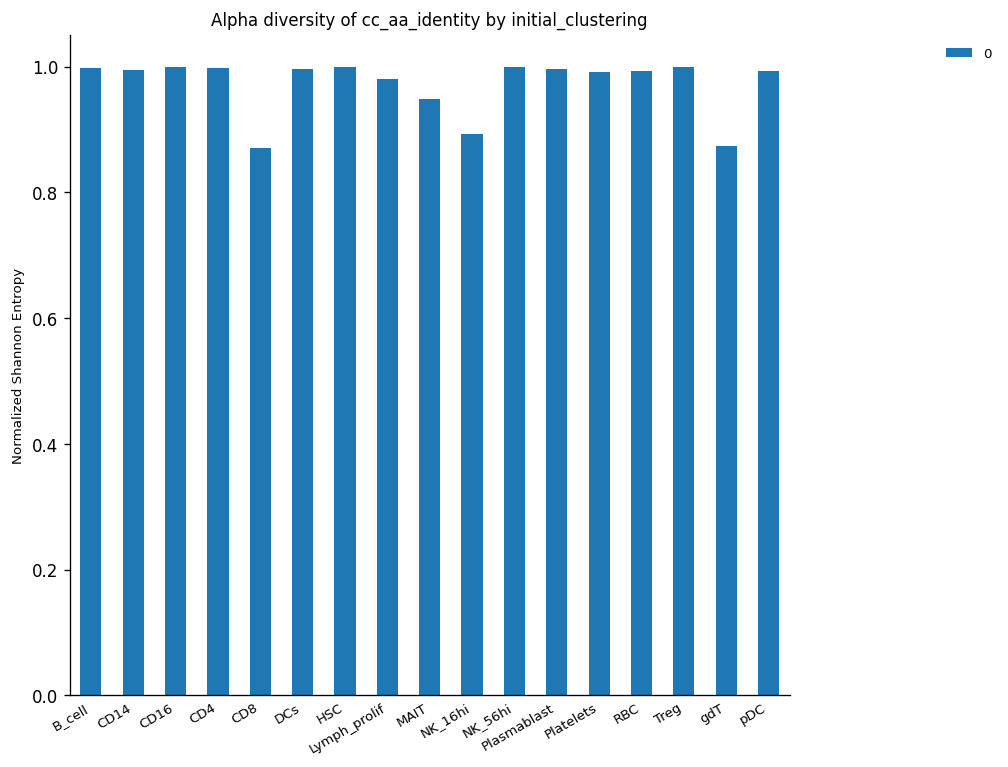

In [7]:
_ = ir.pl.alpha_diversity(adata, groupby="initial_clustering", target_col = "cc_aa_identity", figsize=[10, 10])

# Clonotype abundance

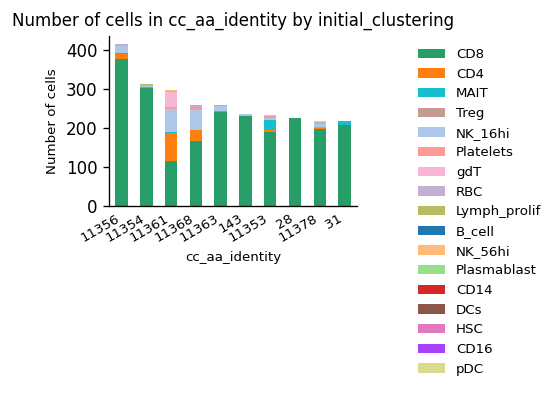

In [20]:
_ = ir.pl.group_abundance(
    adata, groupby="cc_aa_identity", target_col="initial_clustering", max_cols=10
)

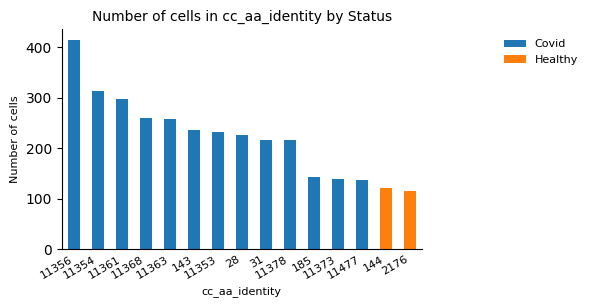

In [21]:
_ = ir.pl.group_abundance(
    adata, groupby="cc_aa_identity", target_col="Status", max_cols=15, fig_kws={"dpi": 100}
)

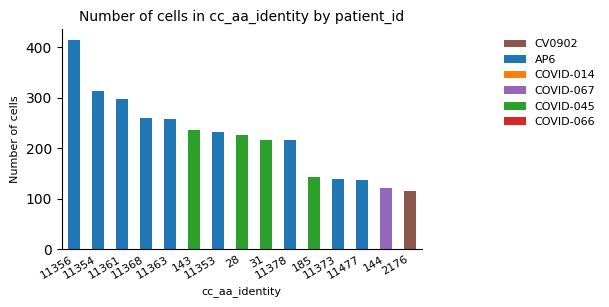

In [22]:
ax = ir.pl.group_abundance(
    adata,
    groupby="cc_aa_identity",
    target_col="patient_id",
    max_cols=15,
    fig_kws={"dpi": 100},
)

# Gene usage

<AxesSubplot:title={'center':'Fraction of initial_clustering in each IR_VJ_1_v_call'}, xlabel='IR_VJ_1_v_call', ylabel='Fraction of cells in initial_clustering'>

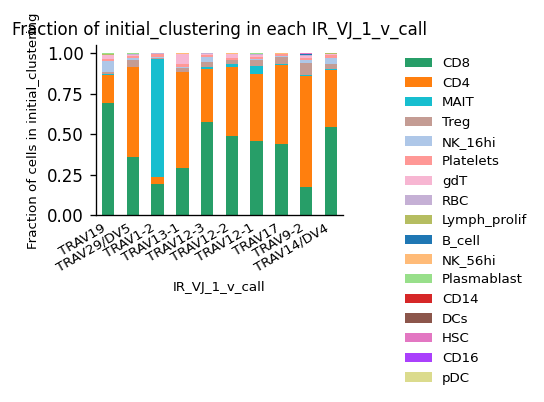

In [23]:
ir.pl.group_abundance(
    adata,
    groupby="IR_VJ_1_v_call",
    target_col="initial_clustering",
    normalize=True,
    max_cols=10,
)

/home/juan.henao/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


<AxesSubplot:title={'center':'Fraction of IR_VDJ_1_v_call in each initial_clustering'}, xlabel='initial_clustering', ylabel='Fraction of cells in IR_VDJ_1_v_call'>

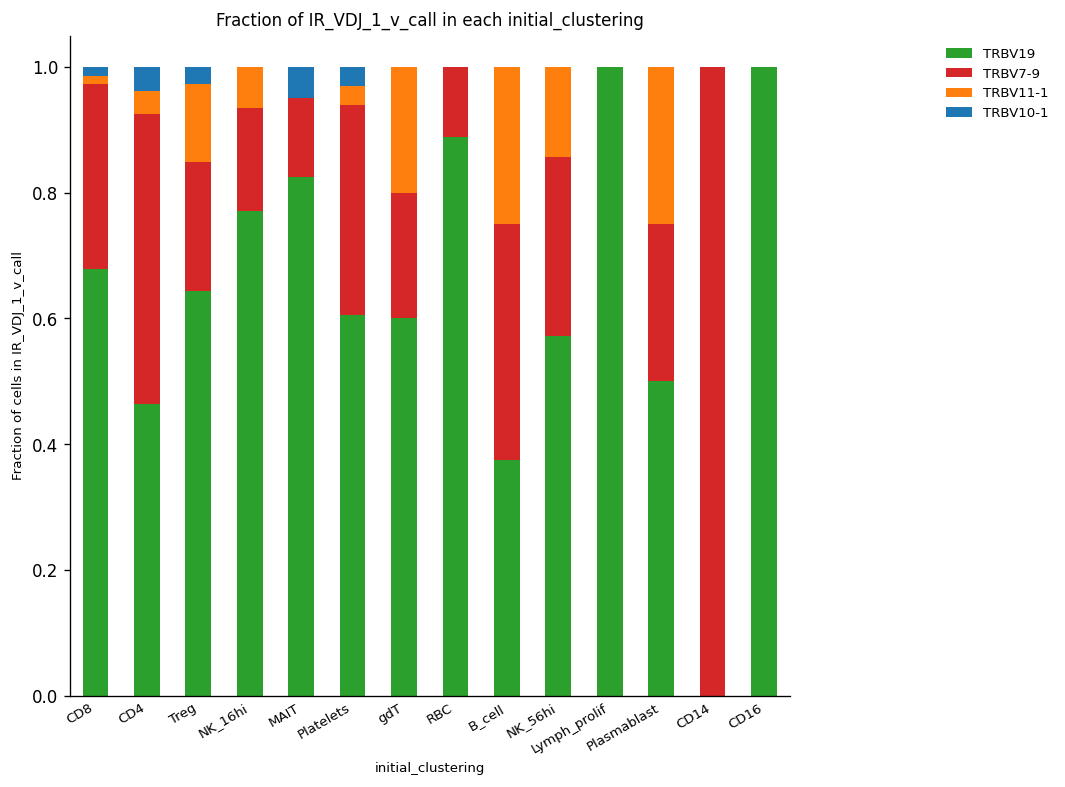

In [24]:
ir.pl.group_abundance(
    adata[
        adata.obs["IR_VDJ_1_v_call"].isin(
            ["TRBV19", "TRBV10-1", "TRBV11-1", "TRBV7-9"]
        ),
        :,
    ],
    groupby="initial_clustering",
    target_col="IR_VDJ_1_v_call",
    normalize=True,
    figsize=[10, 10],
)

<AxesSubplot:>

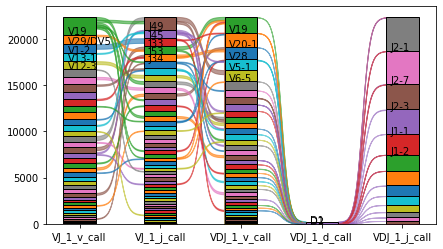

In [25]:
ir.pl.vdj_usage(adata, full_combination=False, max_segments=None, max_ribbons=30)

<AxesSubplot:>

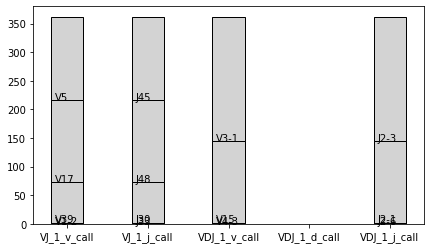

In [26]:
ir.pl.vdj_usage(
    adata[adata.obs["cc_aa_identity"].isin(["31", "273", "185"]), :],
    max_ribbons=None,
    max_segments=100,
)

# Spectratype

<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_junction_aa by initial_clustering'}, xlabel='IR_VJ_1_junction_aa length', ylabel='Number of cells'>

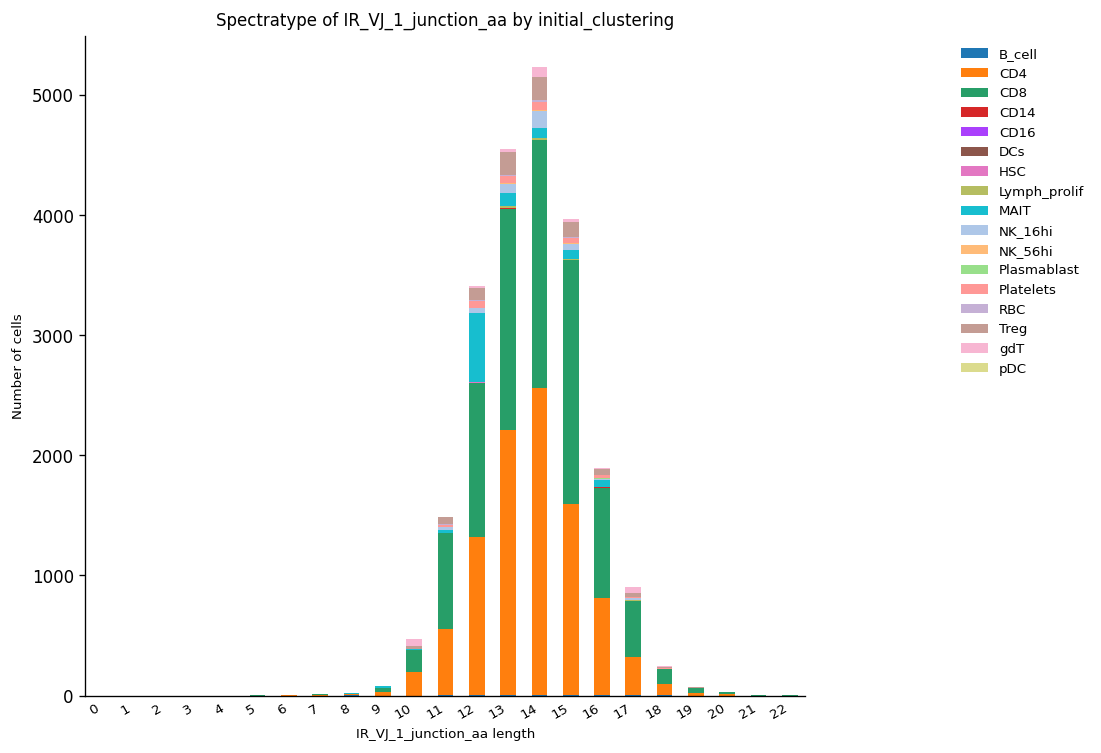

In [27]:
ir.pl.spectratype(
    adata,
    color="initial_clustering",
    viztype="bar",
    fig_kws={"dpi": 120},
    figsize=[10, 10],
)

/home/juan.henao/.local/lib/python3.8/site-packages/scirpy/pl/base.py:262: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order)


<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_junction_aa by initial_clustering'}, xlabel='IR_VJ_1_junction_aa length'>

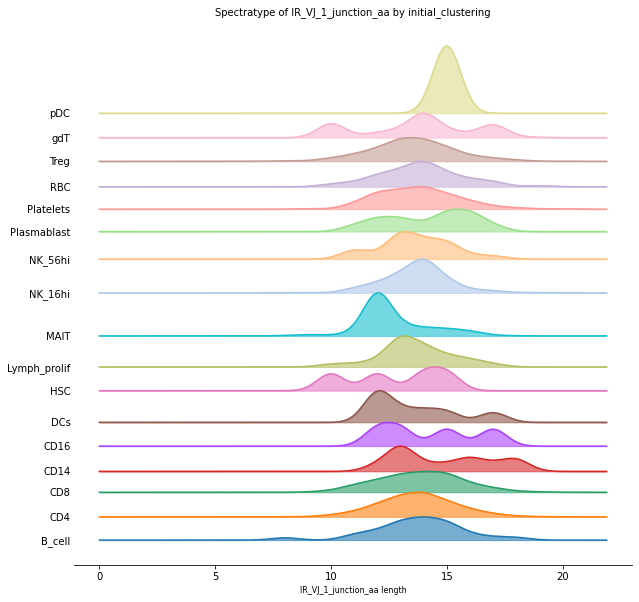

In [28]:
ir.pl.spectratype(
    adata,
    color="initial_clustering",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"figsize": [10, 10]},
    kde_kws={"kde_norm": False},
)

/home/juan.henao/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


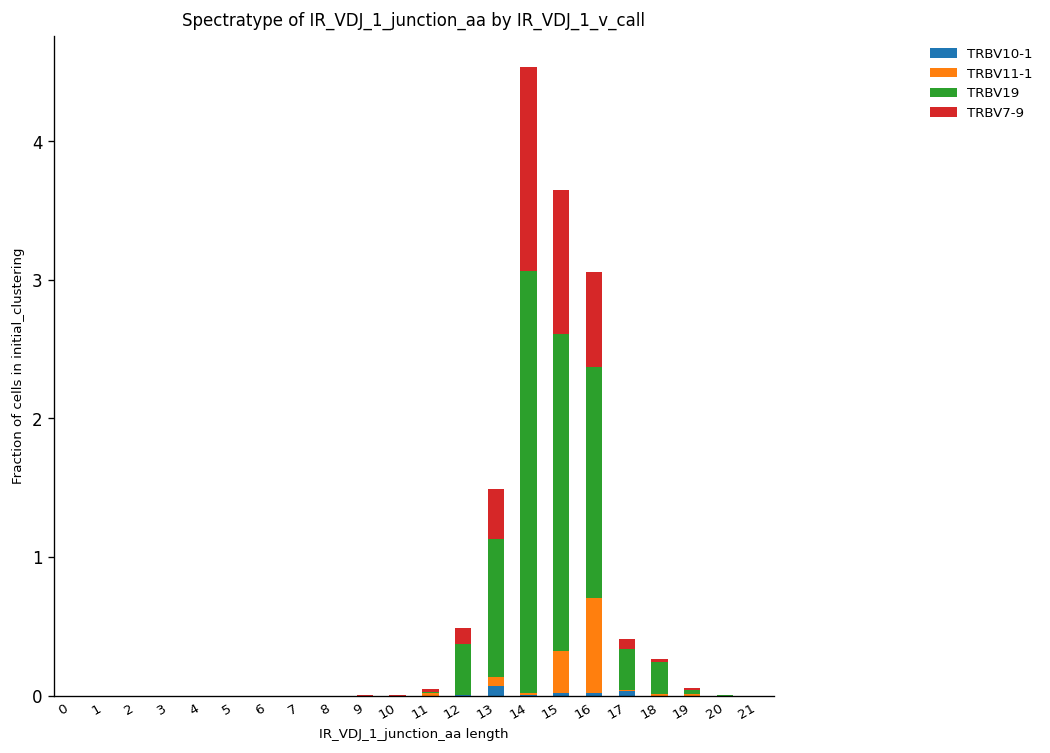

In [29]:
_ = ir.pl.spectratype(
    adata[
        adata.obs["IR_VDJ_1_v_call"].isin(
            ["TRBV19", "TRBV10-1", "TRBV11-1", "TRBV7-9"]
        ),
        :,
    ],
    cdr3_col="IR_VDJ_1_junction_aa",
    color="IR_VDJ_1_v_call",
    normalize="initial_clustering",
    fig_kws={"dpi": 120},
    figsize=[10, 10],
)

# Repertoire comparison

In [31]:
df, dst, lk = ir.tl.repertoire_overlap(adata, "patient_id", target_col = 'cc_aa_identity', inplace=False)

In [32]:
df

cc_aa_identity,0,1,2,3,4,5,6,7,8,9,...,13950,13951,13952,13953,13954,13955,13956,13957,13958,13959
patient_id,,,,,,,,,,,,,,,,,,,,,
AP6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COVID-014,71.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
COVID-045,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
COVID-066,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COVID-067,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
CV0902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
dst

array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 0.9998256, 1.       ])

In [34]:
lk

array([[3.       , 5.       , 0.9998256, 2.       ],
       [0.       , 1.       , 1.       , 2.       ],
       [2.       , 7.       , 1.       , 3.       ],
       [6.       , 8.       , 1.       , 5.       ],
       [4.       , 9.       , 1.       , 6.       ]])

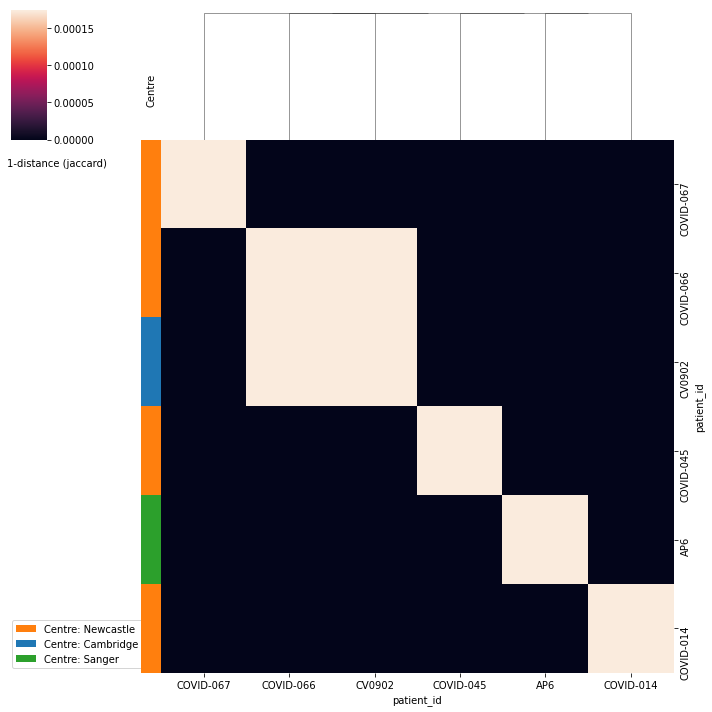

In [36]:
ir.pl.repertoire_overlap(adata, "patient_id", target_col = 'cc_aa_identity', heatmap_cats=["Centre"])

No handles with labels found to put in legend.


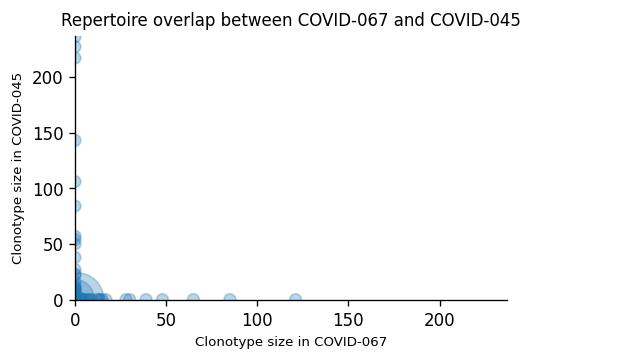

In [37]:
_ = ir.pl.repertoire_overlap(
    adata, "patient_id", pair_to_plot=["COVID-067", "COVID-045"], fig_kws={"dpi": 120}
)

<AxesSubplot:xlabel='cc_aa_identity', ylabel='Normalized abundance'>

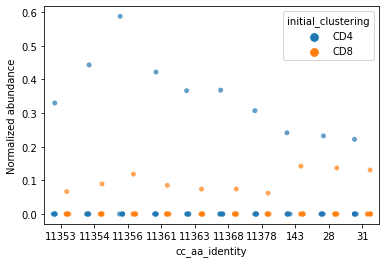

In [39]:
ir.pl.clonotype_imbalance(
    adata,
    replicate_col="patient_id",
    target_col = 'cc_aa_identity',
    groupby="initial_clustering",
    case_label="CD8",
    control_label="CD4",
    plot_type="strip",
)

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Volcano plot'}, xlabel='log2FoldChange', ylabel='-log10(p-value)'>

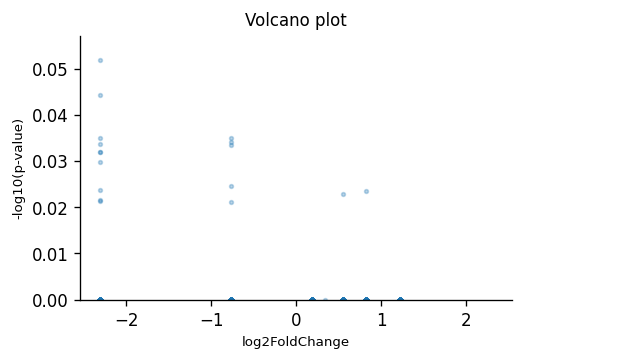

In [40]:
ir.pl.clonotype_imbalance(
    adata,
    replicate_col="sample",
    target_col = 'cc_aa_identity',
    groupby="type",
    case_label="NOD",
    control_label="BulbC",
    plot_type="volcano",
    fig_kws={"dpi": 120},
)

In [41]:
adata.obs["Status"]

cell_id
AAACCTGAGAAACCTA-MH9179824      Covid
AAACCTGAGAACTCGG-MH8919329      Covid
AAACCTGAGACTTGAA-MH8919176    Healthy
AAACCTGAGAGTAATC-MH9179824      Covid
AAACCTGAGAGTGAGA-MH9179824      Covid
                               ...   
TTTGTCATCAGTGCAT-MH8919332    Healthy
TTTGTCATCAGTGTTG-MH8919332    Healthy
TTTGTCATCCGCAAGC-MH8919176    Healthy
TTTGTCATCGCCAAAT-MH8919329      Covid
TTTGTCATCTTTAGTC-MH8919332    Healthy
Name: Status, Length: 22391, dtype: category
Categories (2, object): ['Covid', 'Healthy']

# BCR Data Analysis with Dandelion

In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    ".*IProgress not found*",
)
warnings.simplefilter(action="ignore", category=FutureWarning)

import scanpy as sc
import dandelion as ddl
import scirpy as ir
import pandas as pd
import numpy as np
import seaborn as sb

warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

In [2]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.6.1
sinfo       0.3.1
-----
Bio                         1.79
Levenshtein                 NA
PIL                         8.1.0
adjustText                  NA
airr                        1.3.1
anndata                     0.8.0
anyio                       NA
attr                        20.3.0
babel                       2.9.0
backcall                    0.2.0
brotli                      1.0.9
certifi                     2020.12.05
cffi                        1.14.4
changeo                     1.2.0
chardet                     4.0.0
cloudpickle                 1.6.0
constants                   NA
cycler                      0.10.0
cython_runtime              NA
dandelion                   0.2.1
dask                        2020.12.0
dateutil                    2.8.1
decorator                   4.4.2
descartes                   NA
distance                    NA
fontTools                   4.33.3
future_fstrings             NA
get_version                 

In [33]:
path_data = "/home/icb/juan.henao/BestPracticeStart/data"

path_gex = f"{path_data}/BCR_filtered.h5ad"
adata_bcr = sc.read(path_gex)

In [72]:
adata = adata_bcr[
    adata_bcr.obs["patient_id"].isin(
        ["COVID-030", "IVLPS-6","COVID-027", "COVID-024"]
    )
].copy()

In [73]:
ir.pp.ir_dist(
    adata,
    sequence="aa",
    cutoff=15,
    metric = "hamming"
)

  0%|          | 0/4278 [00:00<?, ?it/s]

  0%|          | 0/21321 [00:00<?, ?it/s]

In [74]:
# Using the previous calculated distances, this function identifies clusters of similar sequences (a.k.a. clonotypes)

ir.tl.define_clonotype_clusters(
    adata, sequence="aa", metric = "hamming", receptor_arms ="VDJ", dual_ir="any"
)

  0%|          | 0/10250 [00:00<?, ?it/s]

In [75]:
# This function use the previous results in the clonotype identification to allow the visualization of them
# as networks

ir.tl.clonotype_network(adata, min_cells=3, sequence="aa", metric = "hamming")

In [ ]:
# Plotting the clonotypes as networks

# Public clonotype: Term to referer a clonotype present in multiple samples, e.g., the clonotype '0'
# Private clonotype: Term to refer a clonotype present exclusively in a specific sample, e.g., clonotype '10982'

ir.pl.clonotype_network(
    adata,
    color="patient_id",
    base_size=10,
    label_fontsize=9,
    panel_size=(10, 10),
    legend_fontsize=15,
)

In [42]:
# Clonotype names as strings
adata.obs["cc_aa_hamming"] = adata.obs["cc_aa_hamming"].astype("str")

In [43]:
# Example of the information necessary to perform further analysis
# The first two columns show the CDR3-alpha region
# The next two columns show the CDR3-beta region
# The next column shows the receptor subtype (T-cell receptor-alpha (TRA), T-cell receptor-beta (TRB))
# The last column shows the number of cells which that specific T-cell receptor were detected

adata.obs.loc[adata.obs["cc_aa_hamming"] == "31", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells


In [14]:
adata.obs.loc[adata.obs["cc_aa_hammingy"] == "0", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells


# Clonal expansion

The positive selection of immune cells, e.g. for immune response activation, causes their clonality (division) relected in the representation of clonotypes in one or more cells. The first step is to identify the clonal expansion and add a column in the .obs table. 

Once the clonal expansion has been identified, it is easy to observe that ploting the raw number of cells per cell-type correspinding to expanded clones as a stacked barplot.

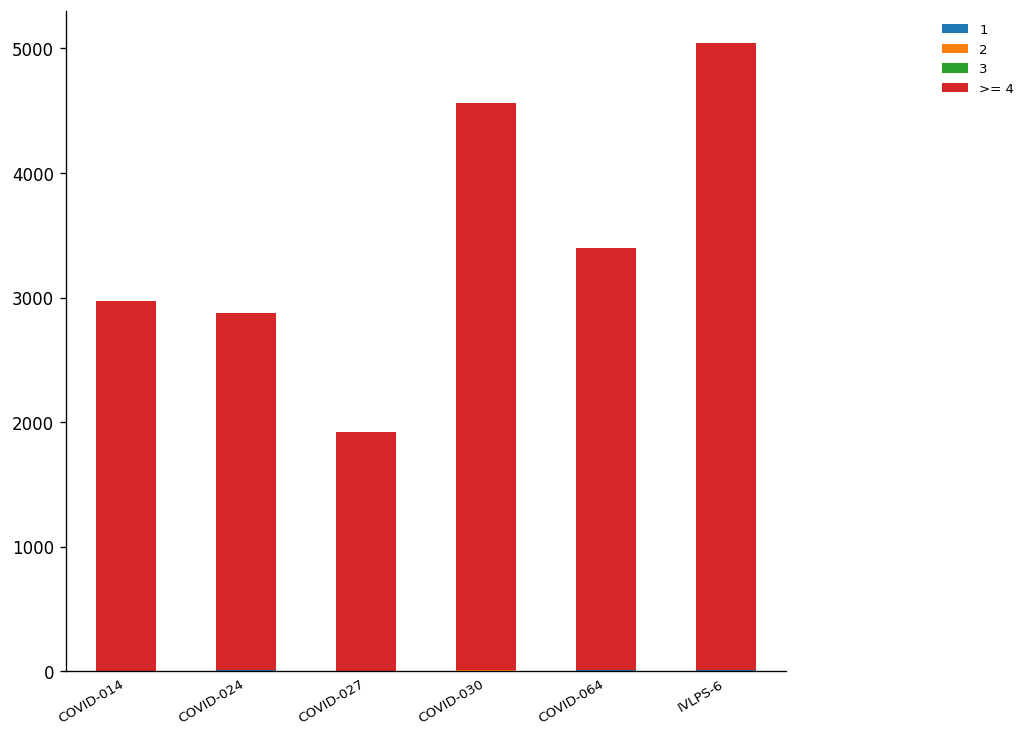

In [46]:
ir.tl.clonal_expansion(adata, target_col = "cc_aa_hamming")

_ = ir.pl.clonal_expansion(
    adata, groupby="patient_id", target_col = "cc_aa_hamming",
    clip_at=4, normalize=False, figsize=[10, 10]
)

The plot above tell us that CD4 is the most abundant cell-type, however, CD8 shows the highest number of clonotypes expanded, it could be possibly by positive selection of CD8 effector cells.

Another way to obser clonal expansion is normalizing the size of cell-type clusters. Here, the clonal expansion differences between CD4 and CD8 are more clear.

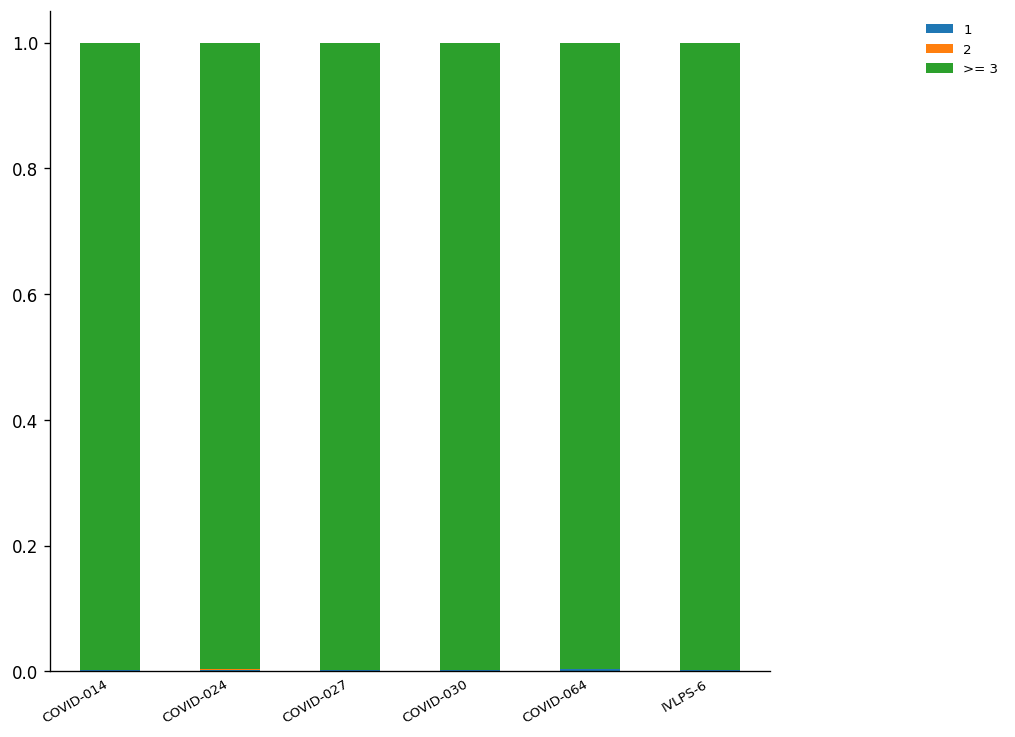

In [47]:
_ = ir.pl.clonal_expansion(adata, "patient_id", target_col = "cc_aa_hamming", figsize=[10, 10])

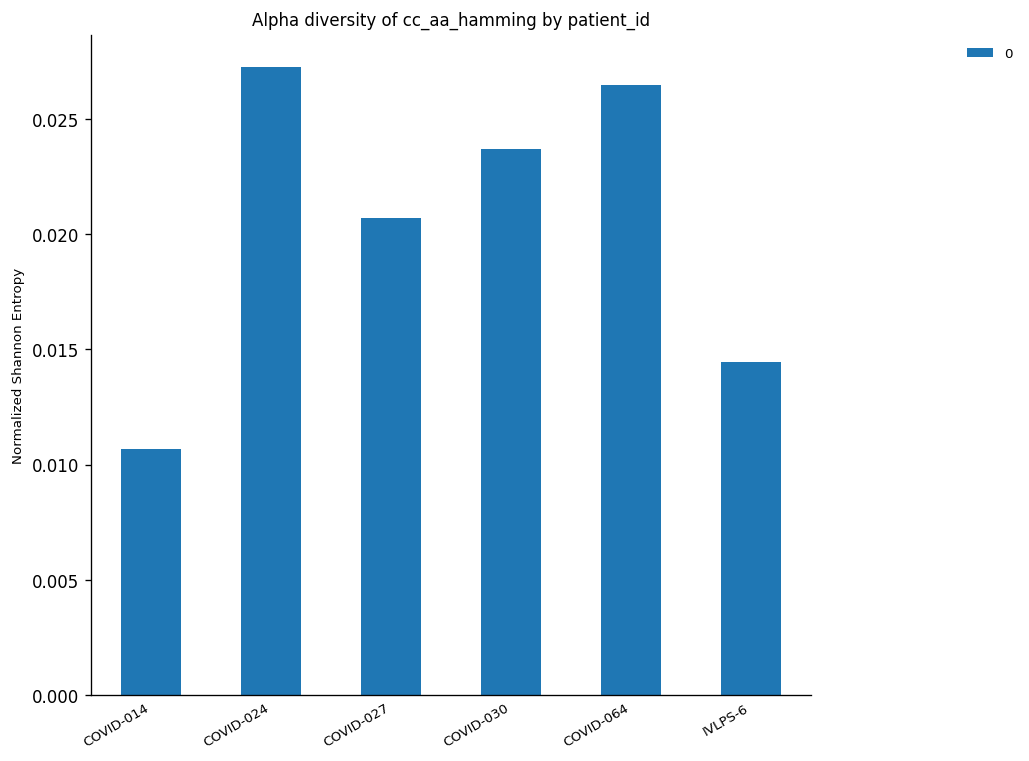

In [48]:
_ = ir.pl.alpha_diversity(adata, groupby="patient_id", target_col = "cc_aa_hamming", figsize=[10, 10])

# Clonotype abundance

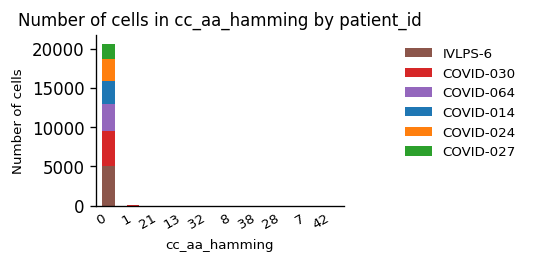

In [49]:
_ = ir.pl.group_abundance(
    adata, groupby="cc_aa_hamming", target_col="patient_id", max_cols=10
)

# Gene usage

<AxesSubplot:title={'center':'Fraction of patient_id in each IR_VJ_1_v_call'}, xlabel='IR_VJ_1_v_call', ylabel='Fraction of cells in patient_id'>

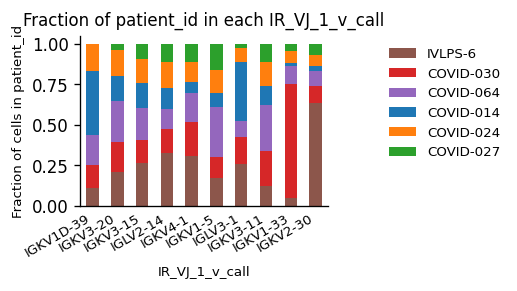

In [53]:
ir.pl.group_abundance(
    adata,
    groupby="IR_VJ_1_v_call",
    target_col="patient_id",
    normalize=True,
    max_cols=10,
)

<AxesSubplot:>

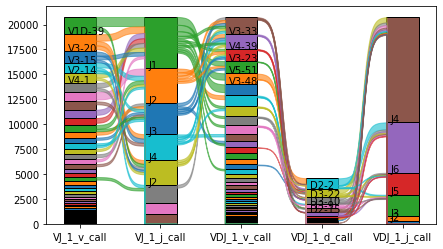

In [54]:
ir.pl.vdj_usage(adata, full_combination=False, max_segments=None, max_ribbons=30)

<AxesSubplot:>

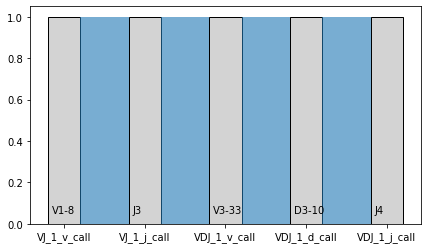

In [55]:
ir.pl.vdj_usage(
    adata[adata.obs["cc_aa_hamming"].isin(["31", "273", "185"]), :],
    max_ribbons=None,
    max_segments=100,
)

# Spectratype

<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_junction_aa by patient_id'}, xlabel='IR_VJ_1_junction_aa length', ylabel='Number of cells'>

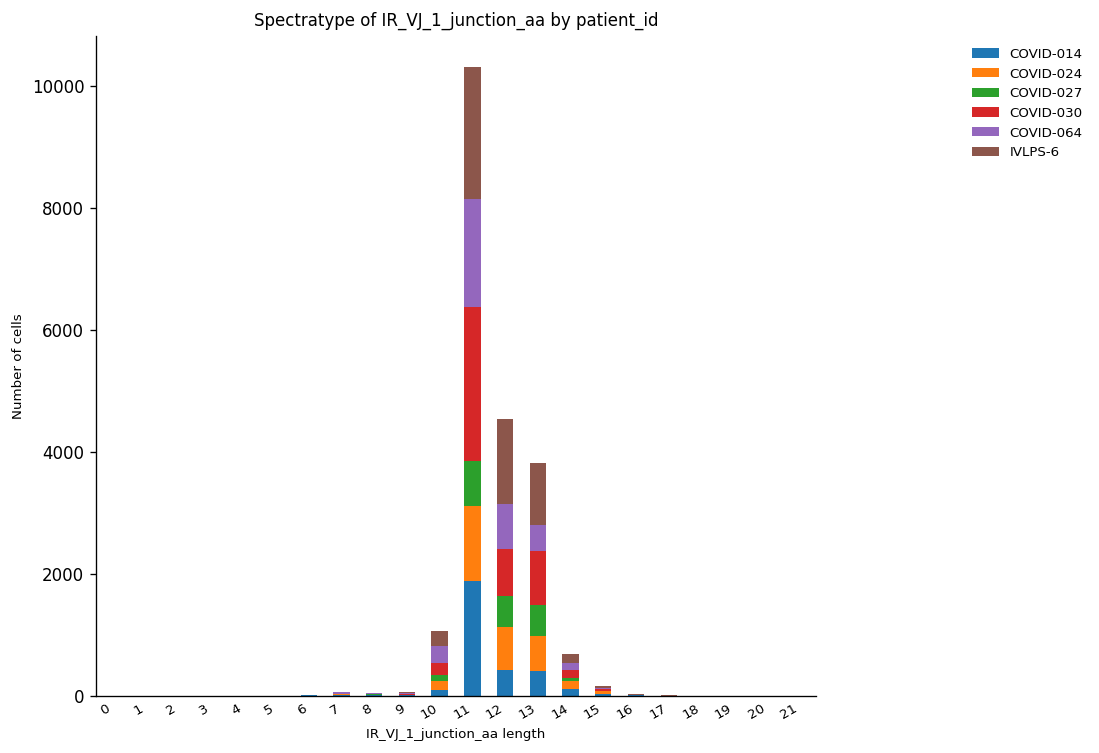

In [56]:
ir.pl.spectratype(
    adata,
    color="patient_id",
    viztype="bar",
    fig_kws={"dpi": 120},
    figsize=[10, 10],
)

<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_junction_aa by patient_id'}, xlabel='IR_VJ_1_junction_aa length'>

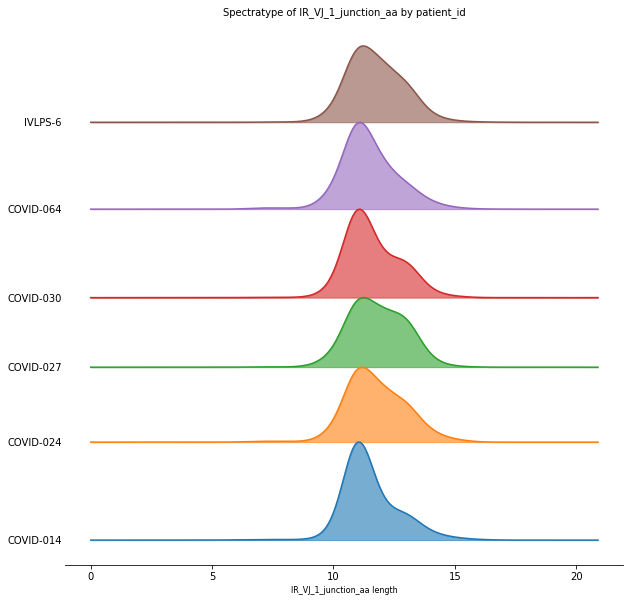

In [57]:
ir.pl.spectratype(
    adata,
    color="patient_id",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"figsize": [10, 10]},
    kde_kws={"kde_norm": False},
)

# Repertoire comparison

In [58]:
df, dst, lk = ir.tl.repertoire_overlap(adata, "patient_id", target_col = 'cc_aa_hamming', inplace=False)

In [59]:
df

cc_aa_hamming,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
patient_id,,,,,,,,,,,,,,,,,,,,,
COVID-014,2961.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COVID-024,2852.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
COVID-027,1914.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
COVID-030,4523.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
COVID-064,3366.0,20.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
IVLPS-6,5022.0,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [60]:
dst

array([0.88235294, 0.83333333, 0.86666667, 0.88888889, 0.89473684,
       0.8125    , 0.9       , 0.91304348, 0.91666667, 0.86666667,
       0.88888889, 0.89473684, 0.9047619 , 0.85714286, 0.92      ])

In [61]:
lk

array([[1.        , 2.        , 0.8125    , 2.        ],
       [0.        , 6.        , 0.83333333, 3.        ],
       [3.        , 5.        , 0.85714286, 2.        ],
       [7.        , 8.        , 0.86666667, 5.        ],
       [4.        , 9.        , 0.88888889, 6.        ]])

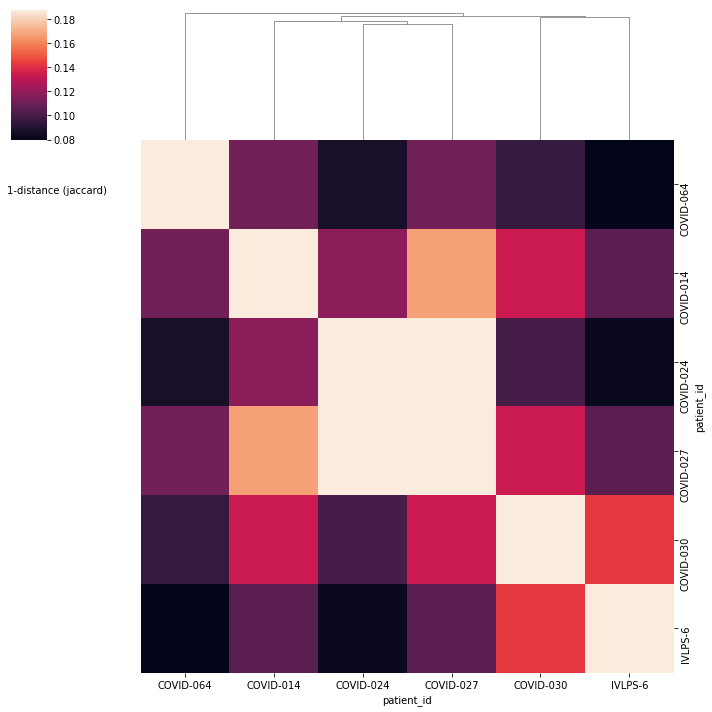

In [67]:
ir.pl.repertoire_overlap(adata, "patient_id", target_col = 'cc_aa_haming')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


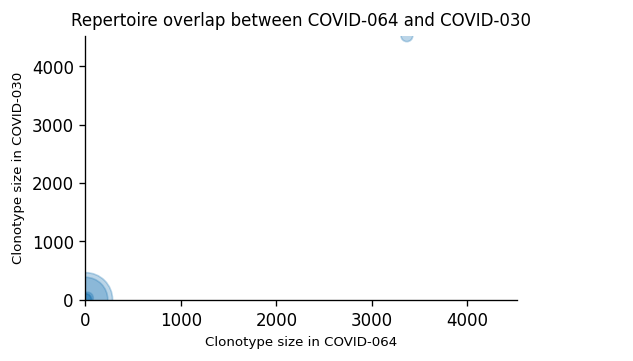

In [68]:
_ = ir.pl.repertoire_overlap(
    adata, "patient_id", pair_to_plot=["COVID-064", "COVID-030"], fig_kws={"dpi": 120}
)